# Modelado de tópicos con NMF y SVD

## El problema

El modelado de tópicos es una forma divertida de comenzar nuestro estudio del NLP. Usaremos dos **técnicas populares de descomposición de matrices**.

Empezamos con una **matriz término-documento**:

|              | Don Quijote | Cien Años de Soledad | La Casa de los Espíritus | Pedro Páramo | La Sombra del Viento |
|--------------|--------------|----------------------|--------------------------|--------------|----------------------|
| QUIJOTE      | 150          | 0                    | 4                        | 0            | 1                    |
| SANCHO       | 120          | 0                    | 0                        | 0            | 0                    |
| ROCINANTE    | 80           | 0                    | 0                        | 0            | 0                    |
| ALONSO       | 50           | 0                    | 0                        | 0            | 0                    |
| ÚRSULA       | 0            | 200                  | 0                        | 2            | 0                    |
| AURELIANO    | 0            | 180                  | 0                        | 2            | 0                    |
| REMEDIOS     | 0            | 150                  | 0                        | 0            | 0                    |
| CLARA        | 0            | 0                    | 170                      | 0            | 0                    |
| ESTEBAN      | 0            | 0                    | 150                      | 0            | 0                    |
| PEDRO        | 2            | 0                    | 0                        | 160          | 0                    |
| JUAN         | 10            | 5                    | 0                        | 140          | 0                    |
| DANIEL       | 0            | 0                    | 0                        | 0            | 180                  |
| JULIÁN       | 0            | 3                    | 0                        | 0            | 150                  |
| BEA          | 0            | 0                    | 0                        | 0            | 120                  |

Podemos descomponer esto en una matriz alta y delgada por una matriz ancha y corta (posiblemente con una matriz diagonal en el medio).

Tenga en cuenta que esta representación no tiene en cuenta el orden de las palabras ni la estructura de las oraciones. Es un ejemplo de un enfoque de **bag of words**.

### Motivación

Considere el caso más extremo: reconstruir la matriz usando un producto externo de dos vectores. Claramente, en la mayoría de los casos no podremos reconstruir la matriz exactamente. Pero si tuviéramos un vector con la frecuencia relativa de cada palabra del vocabulario del conteo total de palabras, y uno con el número promedio de palabras por documento, entonces ese producto externo sería lo más cercano que podemos obtener.

Ahora considere reducir esas matrices a dos columnas y dos filas. La descomposición óptima ahora sería agrupar los documentos en dos grupos, cada uno de los cuales tiene una distribución de palabras lo más diferente posible entre sí, pero lo más similar posible entre los documentos del grupo. Llamaremos a esos dos grupos "tópicos". Y agruparíamos las palabras en dos grupos, en función de las que aparecen con más frecuencia en cada uno de los temas.

## Empezando

Tomaremos un conjunto de datos de documentos en varias categorías diferentes y encontraremos tópicos (que consisten en grupos de palabras) para ellos. Conocer las categorías reales nos ayuda a evaluar si los temas que encontramos tienen sentido.

Probaremos esto con dos factorizaciones de matrices diferentes: **Descomposición de valores singulares (SVD)** y **Factorización de matrices no negativas (NMF)**

In [1]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
import pandas as pd
from sklearn import decomposition
from scipy import linalg
import matplotlib.pyplot as plt

In [2]:
np.set_printoptions(suppress=True)

### Recursos adicionales

- [Fuente de datos](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html): los grupos de noticias son grupos de discusión en Usenet, que fueron populares en los años 80 y 90 antes de que la web realmente despegara. Este conjunto de datos incluye 18 000 publicaciones de grupos de noticias con 20 temas.
- [Capítulo del libro de Chris Manning](https://nlp.stanford.edu/IR-book/pdf/18lsi.pdf) sobre factorización de matrices y LSI
- Scikit learn [detalles de SVD y LSI truncados](http://scikit-learn.org/stable/modules/decomposition.html#lsa)

### Otros tutoriales
- [Scikit-Learn: Clasificación fuera del núcleo de documentos de texto](http://scikit-learn.org/stable/auto_examples/applications/plot_out_of_core_classification.html): utiliza el conjunto de datos [Reuters-21578](https://archive.ics.uci.edu/ml/datasets/reuters-21578+text+categorization+collection) (artículos de Reuters etiquetados con ~100 categorías ), HashingVectorizer
- [Análisis de texto con modelos temáticos para humanidades y ciencias sociales](https://github.com/DARIAH-DE/tatom): utiliza [conjunto de datos de literatura británica y francesa](https://github.com/DARIAH-DE/tatom/tree/develop/data) de Jane Austen, Charlotte Bronte, Victor Hugo y más

## Observando nuestros datos

Scikit Learn viene con una serie de conjuntos de datos incorporados, así como utilidades de carga para cargar varios conjuntos de datos externos estándar. Este es un [gran recurso](http://scikit-learn.org/stable/datasets/), y los conjuntos de datos incluyen precios de viviendas en Boston, imágenes de rostros, parches de bosque, diabetes, cáncer de mama y más. Usaremos el conjunto de datos de los grupos de noticias.

Los grupos de noticias son grupos de discusión en Usenet, que fueron populares en los años 80 y 90 antes de que la web realmente despegara. Este conjunto de datos incluye 18 000 publicaciones de grupos de noticias con 20 temas.

In [3]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
remove = ('headers', 'footers', 'quotes')
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

In [4]:
newsgroups_train.filenames.shape, newsgroups_train.target.shape

((2034,), (2034,))

Echemos un vistazo a algunos de los datos. ¿Puedes adivinar en qué categoría están estos mensajes?

In [5]:
print("\n----------------------------".join(newsgroups_train.data[:3]))

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
----------------------------

Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.
----------------------------
 >In

In [6]:
np.array(newsgroups_train.target_names)[newsgroups_train.target[:3]]

array(['comp.graphics', 'talk.religion.misc', 'sci.space'], dtype='<U18')

El target (etiqueta) es el índice entero de la categoría.

In [7]:
newsgroups_train.target[:10]

array([1, 3, 2, 0, 2, 0, 2, 1, 2, 1])

In [8]:
pd.DataFrame(dict(text = newsgroups_train.data,
                 label = np.array(newsgroups_train.target_names)[newsgroups_train.target])
            ).head(5)

,text,label
0,"Hi,\n\nI've noticed that if you only save a mo...",comp.graphics
1,"\n\nSeems to be, barring evidence to the contr...",talk.religion.misc
2,\n >In article <1993Apr19.020359.26996@sq.sq.c...,sci.space
3,I have a request for those who would like to s...,alt.atheism
4,AW&ST had a brief blurb on a Manned Lunar Exp...,sci.space


In [9]:
num_topics, num_top_words = 6, 8

## Stop words, stemming, lemmatization

### Stop words

De [Intro to Information Retrieval](https://nlp.stanford.edu/IR-book/html/htmledition/dropping-common-terms-stop-words-1.html):

*Algunas palabras extremadamente comunes que parecerían tener poco valor para ayudar a seleccionar documentos que coincidan con las necesidades de un usuario se excluyen por completo del vocabulario. Estas palabras se llaman stop words.*

*La tendencia general en los sistemas de IR a lo largo del tiempo ha sido desde el uso estándar de listas de stop bastante grandes (200-300 términos) hasta listas de stop muy pequeñas (7-12 términos) hasta ninguna lista de stop en absoluto. Los motores de búsqueda web generalmente no utilizan listas de stop.*

#### NLTK

In [10]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

sorted(list(ENGLISH_STOP_WORDS))[:20]

['a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amoungst']

No existe una única lista universal de stop words.

### Stemming and Lemmatization

Del [Information Retrieval](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html) textbook:

¿Las siguientes palabras significan lo mismo?

*organize, organizes, and organizing*

*democracy, democratic, and democratization*

Tanto el Stemming como la Lemmatization generan la forma raíz de las palabras.

La lematización utiliza las reglas sobre un idioma. Los tokens resultantes son todas palabras reales.

"Stemming is the poor-man’s lemmatization." (Noah Smith, 2011) Stemming es una heurística ingenua que corta los extremos de las palabras. Los tokens resultantes pueden no ser palabras reales. La derivación es más rápida.

In [11]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /home/santi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/santi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [12]:
from nltk import stem

In [13]:
wnl = stem.WordNetLemmatizer()
porter = stem.porter.PorterStemmer()

In [14]:
word_list = ['feet', 'foot', 'foots', 'footing']

In [15]:
[wnl.lemmatize(word) for word in word_list]

['foot', 'foot', 'foot', 'footing']

In [16]:
[porter.stem(word) for word in word_list]

['feet', 'foot', 'foot', 'foot']

**Ejercicio**: Ahora, intente  lematizar y usar stemming en las siguientes colecciones de palabras:

- fly, flies, flying
- organize, organizes, organizing
- universe, university

Stemming y lemmatization dependen del lenguaje. Los idiomas con morfologías más complejas pueden mostrar mayores beneficios. Por ejemplo, el sánscrito tiene una gran [gran cantidad de formas verbales](https://en.wikipedia.org/wiki/Sanskrit_verbs).

### Spacy

Stemming y lemmatization dependen de la implementación.

Spacy es una librería de NLP muy moderna y rápida. Spacy es dogmático, ya que normalmente ofrece una forma altamente optimizada de hacer algo (mientras que nltk ofrece una gran variedad de formas, aunque generalmente no están tan optimizadas).

Hay que instalarlo.

si usas conda:
```
conda install -c conda-forge spacy
```
si usas pip:
```
pip install -U spacy
```

A continuación, deberá descargar el modelo en inglés:
```
spacy download en_core_web_sm
```

In [17]:
#!spacy download en_core_web_sm

In [18]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [19]:
doc = nlp(u"Apples and oranges are similar. Boots and hippos aren't.")

print(doc)

Apples and oranges are similar. Boots and hippos aren't.


In [20]:
[token.lemma_ for word in word_list for token in nlp(word) ]

['foot', 'foot', 'foot', 'foot']

Spacy no ofrece un stemmer (ya que la lematización se considera mejor, ¡este es un ejemplo de ser dogmático!)

Las stop words varían de una librería a otra

In [21]:
sorted(list(nlp.Defaults.stop_words))[:20]

["'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also']

**Ejercicio: ¿Qué stop words aparecen en spacy pero no en sklearn?**

**Ejercicio: ¿Y qué stop words están en sklearn pero no spacy?**

### ¿Cuándo usarlos?

<img src="images/skomoroch.png" alt="" style="width: 65%"/>

Durante mucho tiempo se consideraron técnicas estándar, pero a menudo pueden **perjudicar** su rendimiento **si se utiliza el aprendizaje profundo**. El stemming, la lematización y la eliminación de stop words implican desechar información.

Sin embargo, aún pueden ser útiles cuando se trabaja con modelos más simples.

### Otro enfoque: sub-word units o Tokenization

[SentencePiece](https://github.com/google/sentencepiece) de Google, Byte Pair Encoding (BPE)

## Procesamiento de datos

A continuación, scikit learn tiene un método que extraerá todos los recuentos de palabras por nosotros.

In [24]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [25]:
vectorizer = CountVectorizer(stop_words='english')

In [26]:
# Ajustamos el vectorizador a los datos de entrenamiento y transformamos los datos en un formato denso
vectors = vectorizer.fit_transform(newsgroups_train.data).todense() # (documentos, vocabulario)

# El método .todense() convierte la matriz dispersa resultante en una matriz densa para facilitar el trabajo posterior

vectors.shape  

(2034, 26576)

In [27]:
print(len(newsgroups_train.data), vectors.shape)

2034 (2034, 26576)


In [28]:
vocab = np.array(vectorizer.get_feature_names_out())

In [29]:
vocab.shape

(26576,)

In [30]:
vocab[7000:7020]

array(['cosmonauts', 'cosmos', 'cosponsored', 'cost', 'costa', 'costar',
       'costing', 'costly', 'costruction', 'costs', 'cosy', 'cote',
       'couched', 'couldn', 'council', 'councils', 'counsel',
       'counselees', 'counselor', 'count'], dtype=object)

## Singular Value Decomposition (SVD)

"SVD is not nearly as famous as it should be." - Gilbert Strang

Claramente esperaríamos que las palabras que aparecen con más frecuencia en un tópico aparezcan con menos frecuencia en el otro; de lo contrario, esa palabra no sería una buena elección para separar los dos tópicos. Por lo tanto, esperamos que los tópicos sean **ortogonales**.

El algoritmo SVD factoriza una matriz en una matriz con **columnas ortogonales** y una con **filas ortogonales** (junto con una matriz diagonal, que contiene la <**>importancia relativa<**> de cada factor).

<img src="images/svd_fb.png" alt="" style="width: 60%"/>

source: [Facebook Research: Fast Randomized SVD](https://research.facebook.com/blog/2014/09/fast-randomized-svd/)

SVD es una **descomposición exacta**, ya que las matrices que crea son lo suficientemente grandes como para cubrir completamente la matriz original. SVD es extremadamente utilizado en álgebra lineal, y específicamente en ciencia de datos, incluyendo:

- análisis semántico
- recomendaciones/filtrado colaborativo ([entrada ganadora del premio Netflix](https://datajobs.com/data-science-repo/Recommender-Systems-%5BNetflix%5D.pdf))
- calcular la pseudoinversa de Moore-Penrose
- compresión de datos
- análisis de componentes principales

El análisis semántico latente (LSA) utiliza SVD. A veces escuchará que el modelado de tópicos se conoce como LSA.

In [31]:
%time U, s, Vh = linalg.svd(vectors, full_matrices=False)

CPU times: user 5min 12s, sys: 2.52 s, total: 5min 14s
Wall time: 1min 19s


In [32]:
print(U.shape, s.shape, Vh.shape)

(2034, 2034) (2034,) (2034, 26576)


In [33]:
s[:4]

array([433.92698542, 291.51012741, 240.71137677, 220.00048043])

In [34]:
np.diag(np.diag(s[:4]))

array([433.92698542, 291.51012741, 240.71137677, 220.00048043])

En la generalidad del SVD, para una matriz A de dimensiones m x n:

- U es m x r
- s es r x r (a menudo representado como un vector de longitud r)
- Vh es r x n

El valor r representa el rango de la matriz A, que es a lo sumo $\min(m, n)$.

Sin embargo, en la práctica, especialmente para matrices grandes y dispersas (como las utilizadas en modelado de temas), a menudo elegimos r para que sea más pequeño que el rango completo. Esto se llama SVD truncado o aproximación de rango bajo.

r en este contexto representa la cantidad de valores/vectores singulares que queremos conservar. A menudo es mucho más pequeño que $\min(m, n)$.

La elección de r:
- r se elige en función de restricciones computacionales o del nivel deseado de reducción de dimensionalidad.
- En el modelado de temas, r a menudo representa la cantidad de temas que queremos extraer.
- Hay métodos para ayudar a elegir r, como observar el decaimiento de los valores singulares o utilizar técnicas como el método del codo.

El significado de r:
- Cada par de valor/vector singular representa un "concepto" o "tema" en los datos.
- Mantener los primeros r valores/vectores singulares significa que estamos conservando los r conceptos más importantes.
- Esto nos permite aproximar la matriz original con una representación de menor dimensionalidad.

Compensaciones en la elección de r:
- r más pequeño: Más compresión, cálculos más rápidos, pero potencialmente pérdida de información.
- r más grande: Menos compresión, cálculos más lentos, pero potencialmente una representación más precisa.

En el contexto del modelado de temas, r a menudo se elige en función del número deseado de temas, que suele ser mucho menor que el tamaño del vocabulario o el número de documentos. La elección de r es parte del proceso de selección del modelo y puede tener un impacto significativo en la interpretabilidad y calidad de los temas resultantes.

**Ejercicio: Confirme que esto es una descomposición de la `vectors`.**

In [35]:
#Ejercicio: confirmar que U, s, Vh es una descomposición de `vectors`


True

**Ejercicio: Confirme que U, V son ortonormales**

In [36]:
#Ejercicio: Confirmar que U, Vh son ortonormales


True

#### Tópicos

¿Qué podemos decir acerca de los valores singulares s?

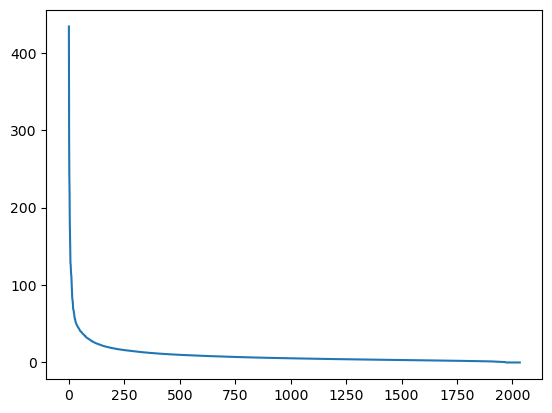

In [37]:
plt.plot(s);

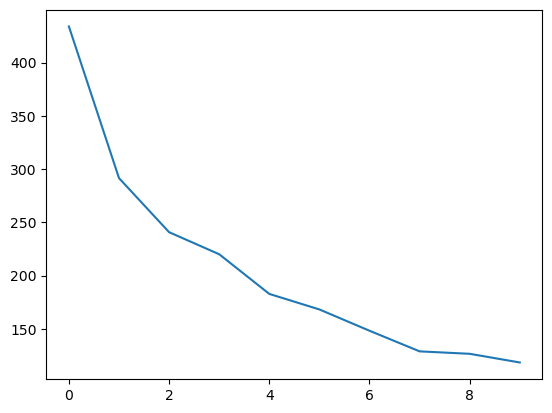

In [38]:
plt.plot(s[:10])

In [39]:
num_top_words=8

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

Expliquemos la función `show_topics` paso a paso:

1. La función `show_topics` toma una matriz `a` donde cada fila representa un tópico.
   
2. Dentro de la función, se define una función lambda `top_words` que realiza lo siguiente:
   - Toma un vector `t` (que representa un tópico)
   - Usa `np.argsort(t)` para obtener los índices que ordenarían `t` de menor a mayor
   - Selecciona los últimos `num_top_words` índices (que corresponden a las palabras más importantes del tópico) usando el slice `[:-num_top_words-1:-1]`
   - Para cada uno de estos índices, obtiene la palabra correspondiente del vocabulario `vocab`

3. Luego, se aplica la función `top_words` a cada fila de la matriz `a`:
   - Esto crea una lista de listas, donde cada lista interna contiene las `num_top_words` palabras más importantes para un tópico.

4. Finalmente, la función retorna una lista donde cada elemento es una cadena que representa un tópico con sus palabras más relevantes unidas por espacios.

En resumen, `show_topics` identifica las palabras más relevantes para cada tópico en una matriz, y las devuelve como una lista de cadenas donde cada una representa un tópico con sus palabras más importantes.


In [40]:
show_topics(Vh[:10])

['ditto critus propagandist surname galacticentric kindergarten surreal imaginative',
 'edu graphics data space pub mail 128 3d',
 'space jesus launch god people satellite matthew atheists',
 'space launch satellite commercial nasa satellites market year',
 'jpeg graphics space pub edu ray mail send',
 'jesus matthew prophecy messiah psalm isaiah david said',
 'launch commercial satellite market image services satellites launches',
 'data available nasa ftp grass anonymous contact gov',
 'atheists god religious atheism religion believe belief atheist',
 'probe data surface moon mars probes lunar launch']

¡Obtenemos tópicos que coinciden con los tipos de grupos que esperaríamos! Esto es a pesar del hecho de que se trata de un **algoritmo no supervisado**, es decir, nunca le dijimos al algoritmo cómo se agrupan nuestros documentos.

Una referencia más teórica de SVD la pueden encontrar en [este libro](https://shainarace.github.io/LinearAlgebra/svd.html)

## Non-negative Matrix Factorization (NMF)

#### Motivación

<img src="images/face_pca.png" alt="PCA on faces" style="width: 80%"/>

(source: [NMF Tutorial](http://perso.telecom-paristech.fr/~essid/teach/NMF_tutorial_ICME-2014.pdf))

Un enfoque más interpretable:

<img src="images/face_outputs.png" alt="NMF on Faces" style="width: 80%"/>

(source: [NMF Tutorial](http://perso.telecom-paristech.fr/~essid/teach/NMF_tutorial_ICME-2014.pdf))

#### Idea

En lugar de restringir nuestros factores para que sean *ortogonales*, otra idea sería restringirlos para que sean *no negativos*. NMF es una factorización de un conjunto de datos no negativos $V$: $$ V = W H$$ en matrices no negativas $W,\; H$. A menudo, los factores positivos serán **más fáciles de interpretar** (y esta es la razón detrás de la popularidad de NMF).

<img src="images/face_nmf.png" alt="NMF on faces" style="width: 80%"/>

(source: [NMF Tutorial](http://perso.telecom-paristech.fr/~essid/teach/NMF_tutorial_ICME-2014.pdf))

La factorización de matriz no negativa (NMF) es una factorización no exacta que se factoriza en una matriz positiva delgada y una matriz positiva corta. NMF es procesamiento numérico fuerte y no es único. Hay una serie de variaciones en él, creadas al agregar diferentes restricciones.

#### Aplicaciones de NMF

- [Face Decompositions](http://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html#sphx-glr-auto-examples-decomposition-plot-faces-decomposition-py)
- [Collaborative Filtering, eg movie recommendations](http://www.quuxlabs.com/blog/2010/09/matrix-factorization-a-simple-tutorial-and-implementation-in-python/)
- [Audio source separation](https://pdfs.semanticscholar.org/cc88/0b24791349df39c5d9b8c352911a0417df34.pdf)
- [Chemistry](http://ieeexplore.ieee.org/document/1532909/)
- [Bioinformatics](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-015-0485-4) and [Gene Expression](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2623306/)
- Topic Modeling (el problema actual)

<img src="images/nmf_doc.png" alt="NMF on documents" style="width: 60%"/>

(source: [NMF Tutorial](http://perso.telecom-paristech.fr/~essid/teach/NMF_tutorial_ICME-2014.pdf))

**Más lecturas**:

- [El porqué y el cómo de la factorización de matrices no negativas](https://arxiv.org/pdf/1401.5226.pdf)

### NMF de sklearn

Usaremos [la implementación de NMF de scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html):

En nuestra situación la matriz documento-término representa los documentos como filas y las palabras como columnas:

![](images/nmf_sklearn.png)

[fuente](https://www.semanticscholar.org/reader/ddf1fe965c2232f029cf7d4cc46d52c3fd6a7b29)

In [41]:
m,n=vectors.shape
d=5  # num topics

In [48]:
clf = decomposition.NMF(n_components=d, random_state=1, init='nndsvda')

W1 = clf.fit_transform(np.asarray(vectors))
H1 = clf.components_

In [49]:
print(W1.shape)
print(H1.shape)

(2034, 5)
(5, 26576)


In [47]:
show_topics(H1)

['jpeg image gif file color images format quality',
 'edu graphics pub mail 128 ray ftp send',
 'space launch satellite nasa commercial satellites year market',
 'jesus god people matthew atheists does atheism said',
 'image data available software processing ftp edu analysis']

### TF-IDF

[Topic Frequency-Inverse Document Frequency](http://www.tfidf.com/) (TF-IDF) es una forma de normalizar el recuento de términos teniendo en cuenta la frecuencia con la que aparecen en un documento, la extensión del documento, y qué tan común/raro es el término.

TF = (# de ocurrencias del término t en el documento) / (# de palabras en los documentos)

IDF = log(# de documentos / # documentos con el término t en él)

**Ejemplo**: Considere un documento que contiene 100 palabras en el que la palabra gato aparece 3 veces. El término frecuencia (es decir, tf) para gato es entonces $(3/100) = 0.03$. Ahora, supongamos que tenemos 10 millones de documentos y la palabra gato aparece en mil de ellos. Entonces, la frecuencia inversa del documento (es decir, idf) se calcula como $\log(10 000 000 / 1 000) = 4$. Por lo tanto, el peso de Tf-idf es el producto de estas cantidades: $$0.03 * 4 = 0.12.$$

In [50]:
vectorizer_tfidf = TfidfVectorizer(stop_words='english')
vectors_tfidf = vectorizer_tfidf.fit_transform(newsgroups_train.data) # (documents, vocab)

In [51]:
W1 = clf.fit_transform(vectors_tfidf)
H1 = clf.components_

In [52]:
show_topics(H1)

['people don think just like objective say morality',
 'graphics thanks files image file program windows know',
 'space nasa launch shuttle orbit moon lunar earth',
 'ico bobbe tek beauchaine bronx manhattan sank queens',
 'god jesus bible believe christian atheism does belief']

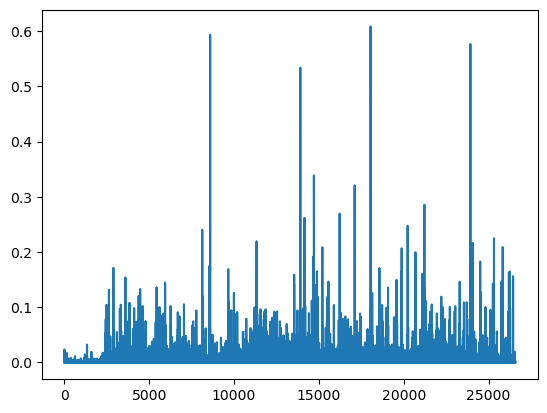

In [53]:
plt.plot(clf.components_[0])

In [54]:
clf.reconstruction_err_

43.71292606348688

### NMF en resumen

Beneficios: ¡Rápido y fácil de usar!

Desventajas: tomó años de investigación y experiencia para crear

Notas:
- Para NMF, la matriz debe ser al menos tan alta como ancha, u obtenemos un error con fit_transform
- Puede usar `df_min` en `CountVectorizer` para ver solo las palabras que estaban en al menos k de los textos divididos.

## SVD truncado

Ahorramos mucho tiempo cuando calculamos NMF calculando solo el subconjunto de columnas que nos interesaba. ¿Hay alguna manera de obtener este beneficio con SVD? ¡Sí hay! Se llama SVD truncado. Solo estamos interesados ​​en los vectores correspondientes a los **mayores** valores singulares.

<img src="images/svd_fb.png" alt="" style="width: 60%"/>

(source: [Facebook Research: Fast Randomized SVD](https://research.fb.com/fast-randomized-svd/))

#### Deficiencias de los algoritmos clásicos para la descomposición:

- Las matrices son "estupendamente grandes"
- Los datos a menudo **faltan o son inexactos**. ¿Por qué gastar recursos computacionales adicionales cuando la imprecisión de la entrada limita la precisión de la salida?
- **La transferencia de datos** ahora juega un papel importante en el tiempo de los algoritmos. Las técnicas que requieren menos pasadas sobre los datos pueden ser sustancialmente más rápidas, incluso si requieren más flops (flops = operaciones de coma flotante).
- Importante aprovechar las **GPUs**.

(fuente: [Halko](https://arxiv.org/abs/0909.4061))

#### Ventajas de los algoritmos aleatorios:

- intrínsecamente estable
- las garantías de rendimiento no dependen de propiedades espectrales sutiles
- los productos matriz-vector necesarios se pueden hacer en paralelo

(fuente: [Halko](https://arxiv.org/abs/0909.4061))

### Comparación de tiempos

In [55]:
%time u, s, v = np.linalg.svd(vectors, full_matrices=False)

CPU times: user 5min 30s, sys: 3.01 s, total: 5min 33s
Wall time: 1min 25s


In [56]:
from sklearn import decomposition
import fbpca #pip install fbpca

In [57]:
%time u, s, v = decomposition.randomized_svd(vectors, 10,random_state=1)

CPU times: user 11.4 s, sys: 956 ms, total: 12.4 s
Wall time: 3.27 s


Randomized SVD from Facebook's library fbpca:

Randomized SVD de la librería `fbpca` de Meta:

In [58]:
%time u, s, v = fbpca.pca(vectors, 10)

CPU times: user 3.34 s, sys: 325 ms, total: 3.66 s
Wall time: 1.06 s
